# Order 2 methods for unconstrained optimization

We will be studying the Rosenbrock function along with it's gradient, just like for the first lab. The functions <code>f</code> and <code>g</code> implement the Rosenbrock function and its gradient

In [1]:
import numpy as np


def f(X, a=1, b=10):
    (x0, x1) = X
    return (x0 - a) ** 2 + b * (x0 ** 2 - x1) ** 2


def g(X, a=1, b=10):
    (x0, x1) = X
    
    dx0 = 2*(x0-a) + 4*b*x0 * (x0**2-x1)
    dx1 = -2*b * (x0**2 - x1)
    
    return np.array([dx0, dx1])

We will also be needing the Hessian.

$$\begin{cases}
\frac{\partial f}{\partial x_0 \partial x_0} = 2 + 4b(x_0^2-x_1) + 8bx_0^2 \\
\frac{\partial f}{\partial x_0 \partial x_1} = -4bx_0 \\
\frac{\partial f}{\partial x_1 \partial x_0} = -4bx_0 \\
\frac{\partial f}{\partial x_1 \partial x_1} = 2b
\end{cases}$$


### Question: 

Implement a function <code>h</code> which provides the hessian of the Rosenbrock function in the form of a <code>2x2</code> numpy array.

In [2]:
def h(X,a=1,b=10):
    (x0, x1) = X
    dxx0 = 2 + 4*b*(x0**2 - x1) + 8*b*x0**2
    dx0x1 = -4*b*x0
    dxx1 = 2*b
    return np.array([[dxx0,dx0x1],[dx0x1,dxx1]])

h([-1,1])

array([[82, 40],
       [40, 20]])

The command <code>h([-1,1])</code> should return <code>array([[82, 40],[40, 20]])</code> 



### Question:
Implement gradient descent with Armijo line search. you can use the code you had during the first lab. Incorporate the stoping criterion.

\begin{equation}
\| \nabla f(x_k,y_k) \|
< \varepsilon \quad \mbox{ou} \quad k \geq itermax.
\end{equation} 
Us the ploting function given below to represent the results.

In [3]:
def RLA(f,g,X,d,p,c):
    c1=c[0]
    while f(X+p*d)>f(X)+c1*p*np.dot(g(X),d):
        p/=2
    return p

def GRL(f,g,R,X0,p0,eps,itermax,c):
    Xn=np.zeros((itermax,len(X0)))
    p=np.zeros(itermax)
    norm=np.zeros(itermax)
    norm[0]=np.linalg.norm(g(X0))
    Xn[0]=X0
    k=1
    while k<itermax and norm[k-1]>=eps:
        a=R(f,g,Xn[k-1],-g(Xn[k-1]),p0,c)
        Xn[k]=Xn[k-1]-a*g(Xn[k-1])
        p[k]=a
        norm[k]=np.linalg.norm(g(Xn[k]))
        k+=1
    return Xn[:k], p[:k], norm[:k]

We will also use the same functions to plot the progress of our optimization methods.

In [4]:
import time
import matplotlib.pyplot as plt


def plot_contour(a, b, c, d, f, ax):
    delta = 0.05
    x0, x1 = np.meshgrid(np.arange(a, b, delta), np.arange(c, d, delta)) 
    ax.contour(x0, x1, f((x0, x1)), 500)


def plot_trace(trace, steps, f, ax):
    for i, (x0, x1) in enumerate(trace):
        ax.plot(x0, x1, color='red', marker='+')
        ax.set_title('Iteration {}; step = {:.5f}; y = {:.5f}'.format(i, steps[i], f((x0, x1))))


Given iterates in a table <code>trace</code> and the coresponding step sizes in <code>steps</code>, the following code illustrates the progress of the algorithm.

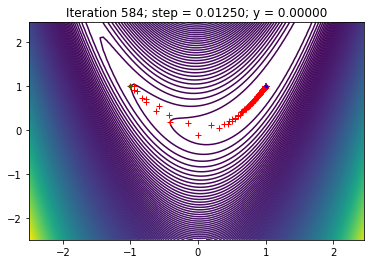

In [5]:
# Compute trace and steps

fig, ax = plt.subplots()
X=np.array([-1.,1.])
trace,steps = GRL(f,g,RLA,X,0.1,1e-4,1000,[0.4])[:2]
plot_contour(-2.5, 2.5, -2.5, 2.5, f, ax)
plot_trace(trace, steps, f, ax)
ax.plot(X[0],X[1],'g.')
ax.plot(1,1,'b.')
plt.ion()
plt.show()

### Question:
If you had other line search strategies implemented in the first lab (Wolfe, exact line search), you can complete them here and include the stoping criterion. Show the progress for each method in terms of norm of the gradient for $\epsilon = 0.1$. Show at least the result for Armijo, you can skip the others if you did not finish the first lab.

In [6]:
def RLW(f,g,X,d,p,c):
    c1,c2=c[0],c[1]
    pmax=100
    pmin=0
    while f(X+p*d)>f(X)+c1*p*d.dot(g(X)) or d.dot(g(X+p*d))<c2*d.dot(g(X)):
        if f(X+p*d)>f(X)+c1*p*d.dot(g(X)):
            pmax=p
            p=(pmin+pmax)/2
        else:
            pmin=p
            p=(pmin+pmax)/2
    return p

def GPE(g,X,itermax,eps):
    Z = np.ones((itermax,len(X)))
    Z[0] = X
    p = np.zeros(itermax)
    norm = np.zeros(itermax)
    norm[0] = np.linalg.norm(g(X))
    Y = X.copy()
    x0,x1 = Y
    d0,d1 = -g(Y)
    i = 1
    while i<itermax and norm[i-1]>=eps:
        t4 = 10*d0**4
        t3 = 40*d0**3*x0 - 20*d0**2*d1
        t2 = 60*d0**2*x0**2 - 20*d0**2*x1 + d0**2 - 40*d0*d1*x0 + 10*d1**2 
        t1 = 40*d0*x0**3 - 40*d0*x0*x1 + 2*d0*x0 - 2*d0 - 20*d1*x0**2 + 20*d1*x1
        t0 = 10*x0**4 - 20*x0**2*x1 + x0**2 - 2*x0 + 10*x1**2 + 1
        root = np.roots([t4,t3,t2,t1,t0])
        root = root[np.where(root>0)]
        root = root[np.where(abs(root.imag)==min(abs(root.imag)))]
        p0 = min(root[np.where(root.real >0)].real)
        p[i] = p0
        Y -= p0*g(Y)
        Z[i] = Y.copy()
        norm[i] = np.linalg.norm(g(Z[i]))
        d0,d1 = -g(Y)
        x0,x1 = Y
        i+=1
    return Z[:i],p[:i],norm[:i]

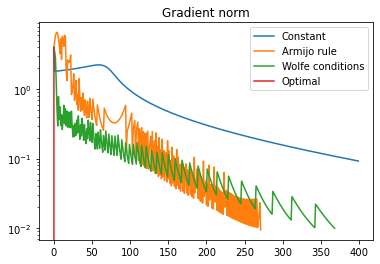

In [7]:
X=np.array([-1.,1.])
plt.semilogy(GRL(f,g,lambda *args: 0.01,X,1,10**(-2),400,[])[2],label='Constant')
plt.semilogy(GRL(f,g,RLA,X,0.1,10**(-2),400,[10**(-4)])[2],label='Armijo rule')
plt.semilogy(GRL(f,g,RLW,X,10,10**(-2),400,[10**(-4),0.999])[2],label='Wolfe conditions')
plt.semilogy(GPE(g,X,400,10**(-2))[2],label='Optimal')
plt.title('Gradient norm')
plt.legend();

## Newton's method

The idea of Newton's method is to use the information contained in the Hessian of `f`. The Hessian is usually denoted as $\nabla^2$ or as $H$. See [this StackExchange thread](https://math.stackexchange.com/questions/609680/newtons-method-intuition) for an intuitive explanation.

The algorithms goes recursively as follows
\begin{align*}
    d_k &= -[\nabla^2 f(x_k)]^{-1} \nabla f(x_k)\\
    x_{k+1} &= x_k + s_k d_k
\end{align*}
where we used matrix inversion and at each iteration $s_k$ is obtained using Armijo Line search with largest possible step equal to 1.

### Question:
Implement newton method, represent succesive iterates as well as the step size chosen by Armijo line search. Use $\epsilon = 10^{-10}$. What happens if you use $s_k = 1$ for all $k$ instead of line search.

In [8]:
def Newton(f,g,h,X,eps,itermax,R=RLA,p0=1,c=[0.4,0.6]):
    Y=np.zeros((itermax,len(X)))
    p=np.zeros(itermax)
    norm=np.zeros(itermax)
    Y[0]=X
    norm[0]=np.linalg.norm(g(X))
    k=1
    while k<itermax and norm[k-1]>=eps:
        d=np.dot(np.linalg.inv(h(Y[k-1])),g(Y[k-1]))
        s=R(f,g,Y[k-1],-d,p0,c)
        Y[k]=Y[k-1]-s*d
        p[k]=s
        norm[k]=np.linalg.norm(g(Y[k]))
        k+=1
    return Y[:k],p[:k],norm[:k]

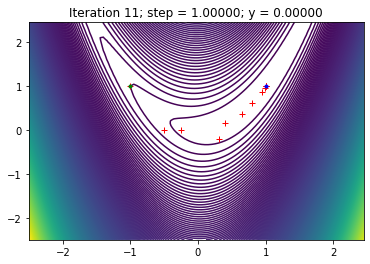

In [9]:
fig, ax = plt.subplots()
X=np.array([-1.,1.])
trace,steps = Newton(f,g,h,X,1e-6,1000,RLW,1,[1e-4,0.999])[:2]
plot_contour(-2.5, 2.5, -2.5, 2.5, f, ax)
plot_trace(trace, steps, f, ax)
ax.plot(X[0],X[1],'g.')
ax.plot(1,1,'b.')
plt.ion()
plt.show()

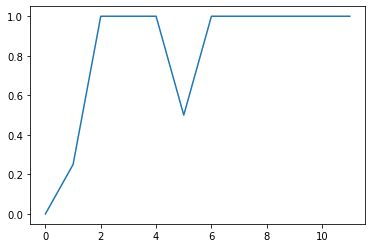

In [10]:
plt.plot(Newton(f,g,h,X,1e-6,1000,RLA,1,[1e-4])[1]);

On remarque que le pas obtenus atteint rapidement 1.

$s_k = 1$ pour tout k à la place de la recherche linéaire:

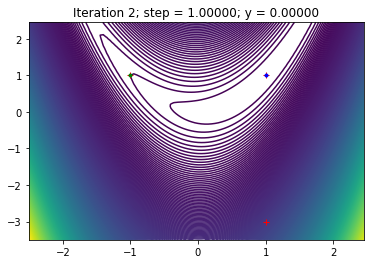

In [11]:
fig, ax = plt.subplots()
X=np.array([-1.,1.])
trace,steps = Newton(f,g,h,X,1e-6,1000,lambda*args:1)[:2]
plot_contour(-2.5, 2.5, -3.5, 2.5, f, ax)
plot_trace(trace, steps, f, ax)
ax.plot(X[0],X[1],'g.')
ax.plot(1,1,'b.')
plt.ion()
plt.show()

### Question  
Represent the evolution of gradient norm, distance to obtimum as well as objective function along Newton iterations in log scale. Newton's method has local quadratic convergence, what do you understand about this affirmation? Comment this based on what you observe. 

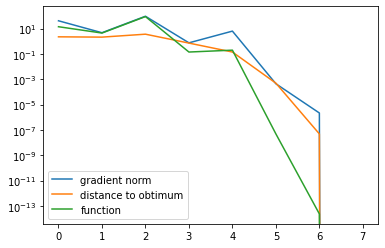

In [12]:
X=np.array([-1.,2])
trace,gra,norm=Newton(f,g,h,X,10**(-6),1000,lambda*args:1)
obj=np.zeros(len(trace))
dist=np.zeros(len(trace))

for i in range(len(obj)):
    obj[i]=f(trace[i])
    dist[i]=np.linalg.norm(trace[i]-np.array([1.,1.]))
    
plt.semilogy(norm,label='gradient norm')    
plt.semilogy(dist,label='distance to obtimum')
plt.semilogy(obj,label='function')

plt.legend();

La convergence de la méthode de Newton est quadratique local. A chaque étape l'approximation devient de plus en plus précise de plus en plus rapidement.

## Quasi-Newton method

The downside of Newton's method is that the Hessian can be difficult to inverse (especially if you're doing deep learning where there can be millions of parameters!). The idea behind [quasi-Newton methods](https://www.wikiwand.com/en/Quasi-Newton_method) is to approximate the Hessian's inverse using the information on the successive gradients. In other words they try to guess the curvature using finited differences. The iterations are as follows
\begin{align*}
       x_{k+1} &= x_k - \rho_k B_k^{-1} \nabla f(x_k) &\text{ where $\rho_k$ is obtained by Armijo line search}.
\end{align*}

There exist many ways to compute the approximate Hessian. The first one ever invented was the [DFP formula](https://www.wikiwand.com/en/Davidon%E2%80%93Fletcher%E2%80%93Powell_formula) while arguably the most popular one is the [BFGS method](https://www.wikiwand.com/en/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm). Each approximation method is defined recursively based on the current Hessian approximation, the difference between the current point and the previous point and and the difference between the current gradient and the previous gradient. 

In practice, the updates on matrix $B_k$ are low rank. Setting $H_k = B_k^{-1}$, the update on $B_k$ results in an equivalent update on $H_k$.

The first Hessian approximation is the identity matrix $I$.

In [13]:
def BFGS(x0,x1,g,H):
    y = np.array([g(x1)-g(x0)])
    s = np.array([x1-x0])
    y = np.reshape(y,(2,1))
    s = np.reshape(s,(2,1))
    a1 = (np.dot(s.T,y) + np.dot(np.dot(y.T,H),y)) * np.dot(s,s.T)/np.dot(s.T,y)**2
    a2 = (np.dot(np.dot(H,y),s.T) + np.dot(np.dot(s,y.T),H))/np.dot(s.T,y)
    H1 = H + a1 - a2
    return H1

The [BFGS method](https://www.wikiwand.com/en/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) is arguably the most popular quasi-Newton method. The update formula is:


\begin{align*}
       \mathbf{s}_k &=  x_{k+1} - x_k\\
       \mathbf{y}_k &= \nabla f(x_{k+1}) - \nabla f(x_k)\\
        B_{k+1} &= B_k + \frac{\mathbf{y}_k \mathbf{y}_k^{\mathrm{T}}}{\mathbf{y}_k^{\mathrm{T}} \mathbf{s}_k} - \frac{B_k \mathbf{s}_k \mathbf{s}_k^{\mathrm{T}} B_k^{\mathrm{T}} }{\mathbf{s}_k^{\mathrm{T}} B_k \mathbf{s}_k}\\
        H_{k+1} &= H_k + \frac{(\mathbf{s}_k^{\mathrm{T}}\mathbf{y}_k+\mathbf{y}_k^{\mathrm{T}} H_k \mathbf{y}_k)(\mathbf{s}_k \mathbf{s}_k^{\mathrm{T}})}{(\mathbf{s}_k^{\mathrm{T}} \mathbf{y}_k)^2} - \frac{H_k \mathbf{y}_k \mathbf{s}_k^{\mathrm{T}} + \mathbf{s}_k \mathbf{y}_k^{\mathrm{T}}H_k}{\mathbf{s}_k^{\mathrm{T}} \mathbf{y}_k}.
\end{align*}
where $H_k = B_k^{-1}$.

### Question:
Implement and represent quasi newton method using the BFGS formula

In [14]:
def QuasiNewton(f,g,R,approx,X,p0,eps,itermax,c=[0.4,0.6]):
    Y=np.zeros((itermax,len(X)))
    p=np.zeros(itermax)
    norm=np.zeros(itermax)
    norm[0]=np.linalg.norm(g(X))
    Y[0]=X
    H = np.eye(2)
    B = np.eye(2)
    k=1
    while k<itermax and norm[k-1]>=eps:
        d=-H.dot(g(Y[k-1]))
        a=R(f,g,Y[k-1],d,p0,c)
        Y[k]=Y[k-1]+a*d
        H=approx(Y[k-1],Y[k],g,H)
        p[k]=a
        norm[k]=np.linalg.norm(g(Y[k]))
        k+=1
    return Y[:k], p[:k], norm[:k]

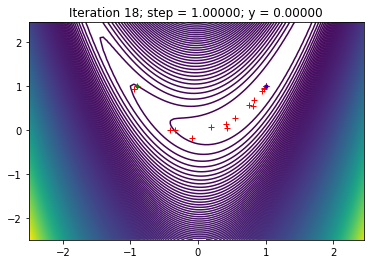

In [15]:
fig, ax = plt.subplots()
X=np.array([-0.9,1.])
trace,steps = QuasiNewton(f,g,RLW,BFGS,X,1,1e-6,1000,[1e-4,0.999])[:2]
plot_contour(-2.5, 2.5, -2.5, 2.5, f, ax)
plot_trace(trace, steps, f, ax)
ax.plot(X[0],X[1],'g.')
ax.plot(1,1,'b.')
plt.ion()
plt.show()

The [DFP formula](https://www.wikiwand.com/en/Davidon%E2%80%93Fletcher%E2%80%93Powell_formula) was the first quasi-Newton method ever proposed. This doesn't mean it is the simplest one! The Hessian update formula is:

\begin{align*}
       s_k &=  x_{k+1} - x_k\\
       y_k &= \nabla f(x_{k+1}) - \nabla f(x_k)\\
       B_{k+1} &= \left(I - \frac{y_k s_k^T}{y_k^T s_k}\right) B_k \left(I - \frac{s_k y_k^T}{y_k^T s_k}\right) + \frac{y_k y_k^T}{y_k^T s_k}\\
       H_{k+1} &= H_k - \frac{H_k y_k y_k^T H_k}{y_k^T H_k y_k} + \frac{s_k s_k^T}{y_k^{T} s_k}
\end{align*}
Notice the similarity (and the differences) with the BFGS formula given above.
### Question:
Implement and represent quasi newton method using the DFP formula



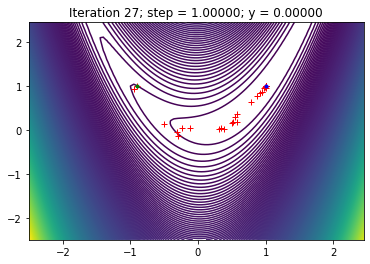

In [16]:
def DFP(x0,x1,g,H):
    y = np.array([g(x1)-g(x0)])
    s = np.array([x1-x0])
    y = np.reshape(y,(2,1))
    s = np.reshape(s,(2,1))
    a1 = np.dot(H,np.dot(y,np.dot(y.T,H)))/np.dot(np.dot(y.T,H),y)
    a2 = np.dot(s,s.T)/np.dot(y.T,s)
    H1 = H - a1 + a2
    return H1

fig, ax = plt.subplots()
X=np.array([-0.9,1.])
trace,steps = QuasiNewton(f,g,RLA,DFP,X,1,1e-6,1000,[1e-4,0.999])[:2]
plot_contour(-2.5, 2.5, -2.5, 2.5, f, ax)
plot_trace(trace, steps, f, ax)
ax.plot(X[0],X[1],'g.')
ax.plot(1,1,'b.')
plt.ion()
plt.show()

### Question:
Compare graphically the progress of newton's method and the two quasi newton methods in terms of devrease of the  objective function, the norm of the gradient and the distance to the optimum. Comment the results. Try to describe comparative advantages and drawbacks for gradient descent methods (first order), newton's method (second order) and quasinewton methods.


In [17]:
X=np.array([-0.9,1.])
trace_BFGS,step_BFGS,norm_BFGS = QuasiNewton(f,g,RLW,BFGS,X,1,1e-15,1000,[1e-4,0.999])
trace_DFP,step_DFP,norm_DFP = QuasiNewton(f,g,RLA,DFP,X,1,1e-15,1000,[1e-4,0.999])
X=np.array([-1,1.])
trace_Newton,step_Newton,norm_Newton = Newton(f,g,h,X,1e-15,1000,RLW,1,[1e-4,0.999])

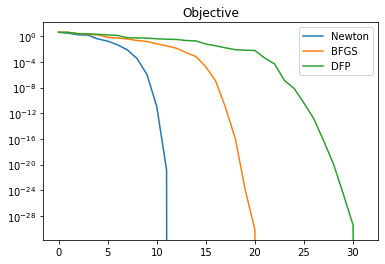

In [18]:
objBFGS = np.zeros(len(trace_BFGS))
objDFP = np.zeros(len(trace_DFP))
objNewton = np.zeros(len(trace_Newton))

for i in range(len(objBFGS)):
    objBFGS[i] = f(trace_BFGS[i])
for i in range(len(objDFP)):
    objDFP[i] = f(trace_DFP[i])
for i in range(len(objNewton)):
    objNewton[i] = f(trace_Newton[i])

plt.semilogy(objNewton,label='Newton')
plt.semilogy(objBFGS,label='BFGS')
plt.semilogy(objDFP,label='DFP')
plt.title('Objective')
plt.legend();

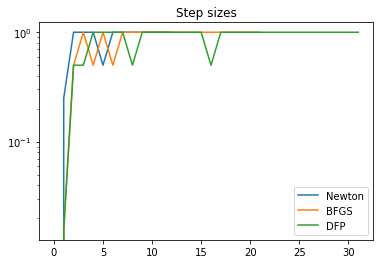

In [19]:
plt.semilogy(step_Newton,label="Newton")
plt.semilogy(step_BFGS,label="BFGS")
plt.semilogy(step_DFP,label="DFP")
plt.title('Step sizes')
plt.legend();

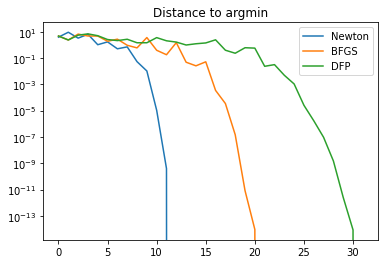

In [20]:
plt.semilogy(norm_Newton,label="Newton")
plt.semilogy(norm_BFGS,label="BFGS")
plt.semilogy(norm_DFP,label="DFP")
plt.title('Distance to argmin')
plt.legend();

La méthode de Newton semble être la plus précise. Les méthodes de Quasi-Newton sont plus rapide comme on ne calcule pas la hessienne à chaque étape mais c'est la formule du BFGS qui semble être le plus efficace parmi les méthodes de Quasi-Newton.